In [107]:
#!pip install nbimporter

In [130]:
from astropy import units as u
from specutils import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from joblib import Parallel, delayed, cpu_count,dump
import joblib  
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import nbimporter
import Functions
import warnings
warnings.filterwarnings('ignore')

## Entrenamiento para dos clases: TT y MS

## Entrenamiento para tres clases: CTT, WTT y MS

In [117]:
# Codigo Entrenamiento para 3 clases.
# Los ficheros de entrada para la creación del dataset se generan en el notebook Pre-entrenamiento

df_ttauri = pd.concat([
    Functions.crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\MS\\fits\\MS.csv"),                    
    Functions.crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Classic\\fits\\Classic.csv"),                       
    #Functions.crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\ClassicWeak\\fits\\ClassicWeak.csv"),
    Functions.crear_dataset2("..\\Catalogos\\vizier\\C-CW-W\\Briceño+Hernandez\\Weak\\fits\\Weak.csv"),
                      ])
df_ttauri = df_ttauri.sample(frac=1).reset_index(drop=True)

In [118]:
# Se muestra el conjunto de datos de entrenamiento según la distribución de las clases

print("clase 1: Classic ",df_ttauri[df_ttauri['Clase']==1].shape)
print("clase 2: ClassicWeak ",df_ttauri[df_ttauri['Clase']==2].shape)
print("clase 3: Weak ",df_ttauri[df_ttauri['Clase']==3].shape)
print("clase 4: MS ",df_ttauri[df_ttauri['Clase']==4].shape)

clase 1: Classic  (113, 24)
clase 2: ClassicWeak  (0, 24)
clase 3: Weak  (576, 24)
clase 4: MS  (913, 24)


In [119]:
# Preparación del dataset

# Se eliminan aquellas filas que contengan NaN
df_ttauri = df_ttauri.dropna()

numeric_cols = ['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                    'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                    'Li b', 'SII', 'SIIb']

df_ttauri[numeric_cols] = df_ttauri[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Se filtra el dataframe para eliminar las filas con valores > 300 o < -300 en las columnas numéricas
df_ttauri = df_ttauri[~df_ttauri[numeric_cols].apply(lambda row: row.gt(300).any() or row.lt(-300).any(), axis=1)]

# Ajustar y transformar el dataset
df_X = df_ttauri [['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                    'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                    'Li b', 'SII', 'SIIb']]
df_Y = df_ttauri [['Clase']]

scaler = MinMaxScaler()
df_X = pd.DataFrame(scaler.fit_transform(df_X), columns=df_X.columns)

# Separar conjuntos train/test  con la proporción 70/30
X_ttauri_train, X_ttauri_test, y_ttauri_train, y_ttauri_test = train_test_split(df_X, df_Y,test_size = 0.3,stratify=df_Y, random_state = 942)

# Selección de variables de entrenamiento
X_ttauri_train = X_ttauri_train[['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                                 'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                                 'Li b', 'SII', 'SIIb']]
X_ttauri_test = X_ttauri_test[['J_H','H_K','Halfa','Hbeta','NII','NIIb','OI','He I','He I b',
                                 'He I c','He I d','He I e','Na D','Ca II H','Ca II K','Li', 
                                 'Li b', 'SII', 'SIIb']]

### Entrenamiento: Regresión Logística

Accuracy en train:  0.8382352941176471
Accuracy en test:  0.85
Precision: 0.850
Recall: 0.850
[[  9  23   0]
 [  0 153  14]
 [  0  20 161]]


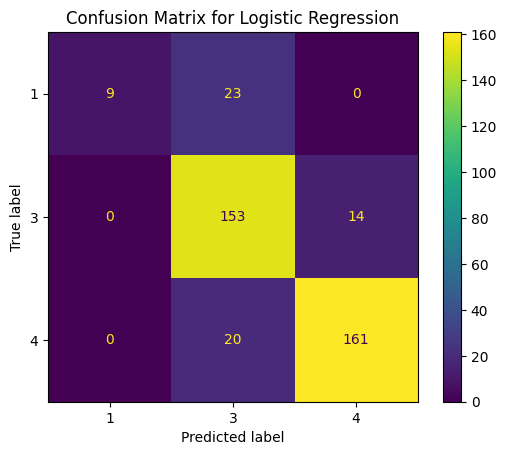

In [120]:
logreg = LogisticRegression(random_state=42,max_iter=10000)
logreg.fit(X_ttauri_train,y_ttauri_train)

print('Accuracy en train: ', logreg.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', logreg.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = logreg.predict(X_ttauri_test)
probs_proy = logreg.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.savefig('RegLog.png')
plt.show()

### Entrenamiento: Arbol de decisión

Accuracy en train:  0.9457013574660633
Accuracy en test:  0.8947368421052632
Precision: 0.895
Recall 0.895
[[ 21   8   3]
 [  2 163   2]
 [  6  19 156]]


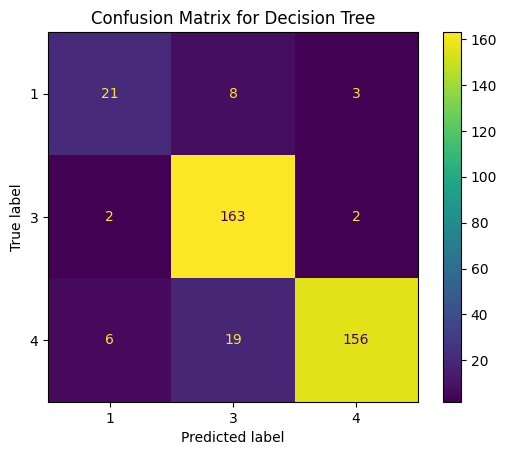

In [121]:
tree_class = DecisionTreeClassifier(criterion='gini',max_depth=8, random_state=42, splitter='random')

# Entrenamiento
tree_class.fit(X_ttauri_train, y_ttauri_train[['Clase']])
print('Accuracy en train: ',tree_class.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ', tree_class.score(X_ttauri_test, y_ttauri_test[['Clase']]))

# Calculamos las métricas globales, con el parámetro average

preds_proy = tree_class.predict(X_ttauri_test)
probs_proy = tree_class.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=tree_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_class.classes_)
disp.plot()
plt.title('Confusion Matrix for Decision Tree')
plt.savefig('DecisionTree.png')
plt.show()

### Entrenamiento: KNN

Accuracy en train:  0.919683257918552
Accuracy en test:  0.9157894736842105
Precision: 0.916
Recall 0.916
[[ 23   7   2]
 [  2 161   4]
 [  8   9 164]]


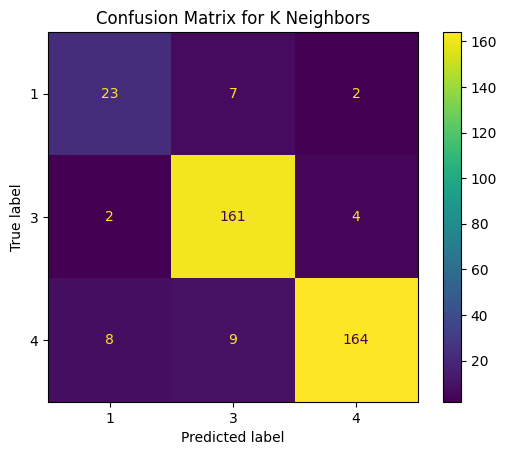

In [122]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',knn.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',knn.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = knn.predict(X_ttauri_test)
probs_proy = knn.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot()
plt.title('Confusion Matrix for K Neighbors')
plt.savefig('KNeighbors.png')
plt.show()

### Entrenamiento SVC

Accuracy en train:  0.8857466063348416
Accuracy en test:  0.8973684210526316
Precision: 0.897
Recall 0.897
[[ 20  11   1]
 [  0 161   6]
 [  2  19 160]]


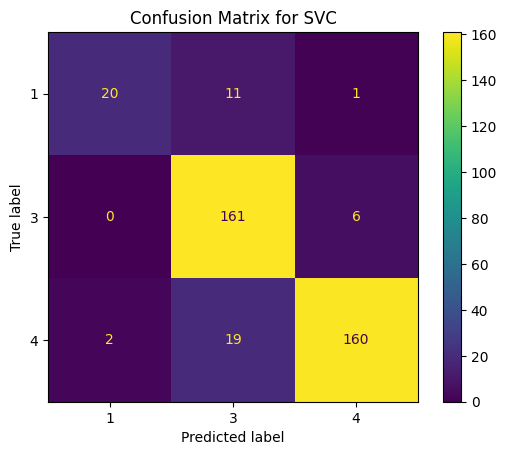

In [123]:
svc = SVC(random_state=42,probability=True) # parámetros por defecto

svc.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())
print('Accuracy en train: ',svc.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',svc.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = svc.predict(X_ttauri_test)
probs_proy = svc.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc.classes_)
disp.plot()
plt.title('Confusion Matrix for SVC')
plt.savefig('SVC.png')
plt.show()

### Entrenamiento MLP

Accuracy en train:  0.8631221719457014
Accuracy en test:  0.8736842105263158
Precision: 0.874
Recall 0.874
[[ 18  13   1]
 [  0 152  15]
 [  0  19 162]]


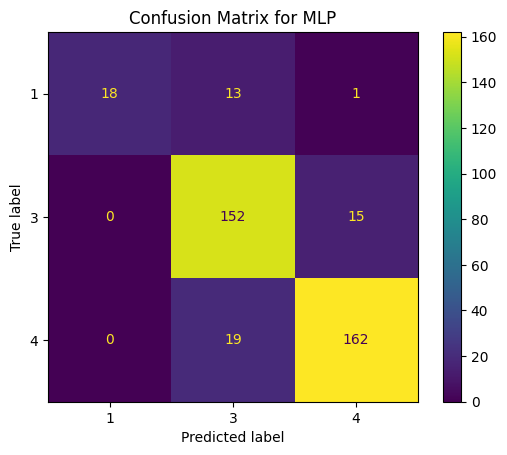

In [124]:
mlp = MLPClassifier(random_state = 42,max_iter=1500)

mlp.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',mlp.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',mlp.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = mlp.predict(X_ttauri_test)
probs_proy = mlp.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mlp.classes_)
disp.plot()
plt.title('Confusion Matrix for MLP')
plt.savefig('MLP.png')
plt.show()

### Entrenamiento Random Forest

Accuracy en train:  1.0
Accuracy en test:  0.9552631578947368
Precision: 0.955
Recall 0.955
[[ 22   9   1]
 [  1 163   3]
 [  0   3 178]]


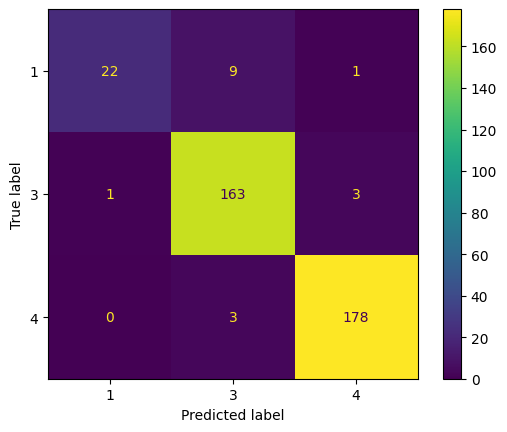

In [125]:
rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_ttauri_train, y_ttauri_train[['Clase']].values.ravel())

print('Accuracy en train: ',rforest.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',rforest.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = rforest.predict(X_ttauri_test)
probs_proy = rforest.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rforest.classes_)
disp.plot()

plt.show()

### Optimización de Hiperparámetros

In [73]:
from sklearn.model_selection import GridSearchCV

print("\nRegresión Lógistica")
grid_parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              #{'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]

grid_log = GridSearchCV(estimator = logreg,  
                           param_grid = grid_parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_log.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_log.best_params_)
print(grid_log.best_score_)
print(grid_log.best_estimator_)

print("\nÁrboles de decisión")
# Parámetros de búsqueda y posibles valores
grid_parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'],'max_depth' : [1,2,3,4,5,6,7,8] }

grid_Tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')
grid_Tree.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_Tree.best_params_)
print(grid_Tree.best_score_)
print(grid_Tree.best_estimator_)

print("\nKNN")
k_range = list(range(1, 31))
grid_parameters = dict(n_neighbors=k_range)

grid_KNN = GridSearchCV(KNeighborsClassifier(),param_grid = grid_parameters, cv = 10, scoring = 'accuracy')
grid_KNN.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_KNN.best_params_)
print(grid_KNN.best_score_)
print(grid_KNN.best_estimator_)

print("\nSVC")
grid_parameters = {'kernel': ['linear', 'rbf', 'poly'], 'C': [10.0, 1.0, 0.1, 0.01, 0.001]}

grid_SVC = GridSearchCV(SVC(random_state=42), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')
grid_SVC.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_SVC.best_params_)
print(grid_SVC.best_score_)
print(grid_SVC.best_estimator_)

print("\nMLP")
grid_parameters = {'hidden_layer_sizes': [(20,), (30,), (15, 15)], 
                   'activation': ['tanh', 'relu'] }

grid_MLP = GridSearchCV(MLPClassifier(random_state=42,max_iter=15000), param_grid = grid_parameters, cv = 3, scoring = 'accuracy')
grid_MLP.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_MLP.best_params_)
print(grid_MLP.best_score_)
print(grid_MLP.best_estimator_)

print("\nRandom Forest")

param_grid = {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }

grid_rforest = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 42),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_rforest.fit(X_ttauri_train, y_ttauri_train.values.ravel())

print(grid_rforest.best_params_)
print(grid_rforest.best_score_)
print(grid_rforest.best_estimator_)


Regresión Lógistica
{'C': 100}
0.871070878274268
LogisticRegression(C=100, max_iter=10000, random_state=42)

Árboles de decisión
{'criterion': 'entropy', 'max_depth': 6, 'splitter': 'best'}
0.903851031938199
DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

KNN
{'n_neighbors': 1}
0.9105720122574056
KNeighborsClassifier(n_neighbors=1)

SVC
{'C': 10.0, 'kernel': 'rbf'}
0.8970905876474884
SVC(C=10.0, random_state=42)

MLP
{'activation': 'relu', 'hidden_layer_sizes': (20,)}
0.8722010838233598
MLPClassifier(hidden_layer_sizes=(20,), max_iter=15000, random_state=42)

Random Forest
{'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150}
0.9392890772128062
RandomForestClassifier(max_features=7, n_estimators=150, random_state=42)


### Optimizando Random Forest 

Accuracy en train:  0.9287330316742082
Accuracy en test:  0.9105263157894737
Precision: 0.911
Recall 0.911
[[ 27   4   1]
 [ 10 150   7]
 [ 11   1 169]]


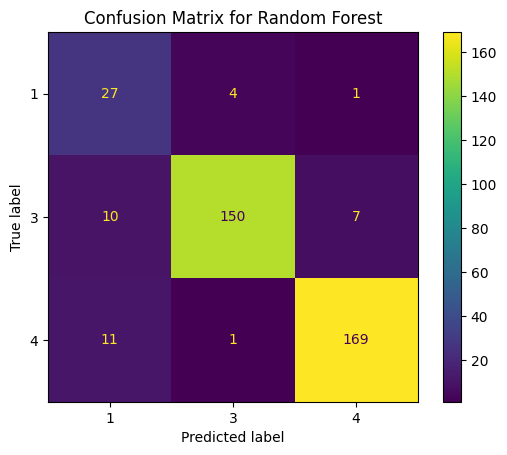

In [131]:
smote = SMOTE(random_state=42)
X_ttauri_train_resampled, y_ttauri_train_resampled = smote.fit_resample(X_ttauri_train, y_ttauri_train)

# Entrenar un modelo (ej. RandomForest) con los datos equilibrados
rforest = RandomForestClassifier(random_state=42)

rforest = RandomForestClassifier(
                #max_depth=15,
                n_estimators=150,
                criterion='gini',
                #class_weight='balanced',
                class_weight ={1: 2, 2: 1,3:1,4: 1},
                min_samples_leaf=15,
                oob_score=True,
                n_jobs=-1,
                random_state=42,
             )

rforest.fit(X_ttauri_train_resampled, y_ttauri_train_resampled[['Clase']].values.ravel())

print('Accuracy en train: ',rforest.score(X_ttauri_train, y_ttauri_train[['Clase']]))
print('Accuracy en test: ',rforest.score(X_ttauri_test, y_ttauri_test[['Clase']]))

preds_proy = rforest.predict(X_ttauri_test)
probs_proy = rforest.predict_proba(X_ttauri_test)
precision = precision_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
recall = recall_score(y_ttauri_test[['Clase']], preds_proy, average = 'micro')
cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy)

print('Precision: %.3f' % precision)
print('Recall %.3f' % recall)
print(cm)

cm = confusion_matrix(y_ttauri_test[['Clase']], preds_proy, labels=rforest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rforest.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.savefig('RandomForest.png')
plt.show()

In [133]:
dump(rforest, 'rforest_final.joblib')

['rforest_final.joblib']